# BDC Option Strategy

## Outline
### 1. Construct Option Collar
### 2. Data Preprocessing
### 3. Bounded Option Optimization
### 4. Unbounded Option Optimization

## 1. Construction Option Collar:

1. Give a "moneyness" threshold, find a collar for each asset in the replicating portfolio
2. Option collar strategy is a linear combination of OTM calls and puts such that the weighted average strike is the "moneyness strike"
3. Put leg and call leg are assumed to be 100 contracts (10,000 shares underlying)
    * This avoids purchasing fractional option contracts
    * Solver is implemented to efficiently find linear combination. This is necessary since you can only assume to buy or sell contracts for a contracts which have crossed the spread
    * Solver takes too long when no upperbound on total contracts is specified
4. All contracts have 1 month-until expiration for monthly rebalancing and contracts are left to naturally expire

Notes: 

* I use the close price from QUANDL data because the adjusted close does not align with option strikes and would have to be manually calcualted for all dividends and stock splits

* I initially wanted to also delta hedge this collar strategy but it already acrues a fair amount of transaction costs and does a good job hedging out large movements in replicating assets

Future Considerations:

* Test different thresholds for "moneyness", contract expiration, rebalancing

* Fix the code to update after each previous contract expirary date (currently it only jumps a number of dates ahead)

* Incorporate optimal hedge ratio to proportionally weight the collar for each asset

* Fix statistics (I only did a very small analysis)


## 2. Data Preprocessing

### Imports

In [333]:
import os
import datetime
import quandl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import plotnine as p9
import quandl
import seaborn as sns
import statsmodels.api as sm
from itertools import combinations
import gurobipy as gp
from gurobipy import GRB

In [334]:
api_key = os.environ.get('QUANDL_API_KEY')

In [335]:
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(r"C:\Users\alexa\OneDrive - The University of Chicago\FINM_33150", "quandl_data_table_downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key=api_key, **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )

### Data Fetching

In [336]:
equities = fetch_quandl_table('QUOTEMEDIA/PRICES', avoid_download=False, ticker=['HYG', 'XLF', 'IWM'], date={'gte': '2017-01-01', 'lte': '2023-03-01'})
equities['date'] = pd.to_datetime(equities['date'])
equities = equities.dropna(subset=['date'])
equities.head()

Data file C:\Users\alexa\OneDrive - The University of Chicago\FINM_33150\quandl_data_table_downloads\QUOTEMEDIA/PRICES_20240305.zip size 227131 exists already, no need to download


,ticker,date,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume
0,HYG,2017-01-03,86.88,86.95,86.70,86.91,14050110.0,0.0,1.0,61.954785,62.004703,61.826426,61.976179,14050110.0
1,HYG,2017-01-04,87.00,87.39,87.00,87.38,11912356.0,0.0,1.0,62.040358,62.318470,62.040358,62.311339,11912356.0
2,HYG,2017-01-05,87.26,87.42,87.20,87.25,10458576.0,0.0,1.0,62.225766,62.339863,62.182980,62.218635,10458576.0
3,HYG,2017-01-06,87.16,87.28,87.04,87.23,6836425.0,0.0,1.0,62.154455,62.240028,62.068883,62.204373,6836425.0
4,HYG,2017-01-09,87.21,87.28,87.05,87.21,6648800.0,0.0,1.0,62.190111,62.240028,62.076014,62.190111,6648800.0


In [337]:
option_raw = pd.read_csv("bdc_rep_options.csv")
option_raw['date'] = pd.to_datetime(option_raw['date'])
option_raw['exdate'] = pd.to_datetime(option_raw['exdate'])
option_raw['strike_price'] = option_raw['strike_price'] / 1000
option_raw['mid_price'] = (option_raw['best_bid'] + option_raw['best_offer']) / 2
option_raw = option_raw.dropna(subset=['date'])

C:\Users\alexa\AppData\Local\Temp\ipykernel_34752\3991702022.py:1: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.


In [338]:
grouped = option_raw.groupby('date').ticker.agg(set)
all_tickers = set.union(*grouped)

# Find dates where all tickers are present
complete_dates = [date for date, tickers in grouped.items() if tickers == all_tickers]

# Filter the original DataFrame for only those dates where all tickers are present
option_raw = option_raw.loc[option_raw.date.isin(complete_dates)]

option_raw.head()

,secid,date,symbol,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,...,vega,theta,optionid,contract_size,cusip,ticker,index_flag,issuer,exercise_style,mid_price
0,106445,2017-01-04,IWM 170203C121500,2017-02-03,NaN,C,121.5,16.36,16.75,0,...,3.643761,-6.815848,114347520,100,46428765,IWM,0,BLACKROCK INSTITUTIONAL TRUS,A,16.555
1,106445,2017-01-04,IWM 170203C122000,2017-02-03,NaN,C,122.0,15.88,16.27,0,...,3.915275,-7.215053,114347521,100,46428765,IWM,0,BLACKROCK INSTITUTIONAL TRUS,A,16.075
2,106445,2017-01-04,IWM 170203C122500,2017-02-03,NaN,C,122.5,15.40,15.81,0,...,4.279741,-7.804613,114347522,100,46428765,IWM,0,BLACKROCK INSTITUTIONAL TRUS,A,15.605
3,106445,2017-01-04,IWM 170203C123000,2017-02-03,NaN,C,123.0,14.95,15.29,0,...,4.504757,-8.052020,114347523,100,46428765,IWM,0,BLACKROCK INSTITUTIONAL TRUS,A,15.120
4,106445,2017-01-04,IWM 170203C123500,2017-02-03,NaN,C,123.5,14.42,14.82,0,...,4.593416,-7.984991,114347524,100,46428765,IWM,0,BLACKROCK INSTITUTIONAL TRUS,A,14.620


### Helper Functions

In [339]:
def get_options(ticker, date):
    
    # Find the current price of the stock
    current_price = equities[(equities['ticker'] == ticker) & (equities['date'] == date)]['close'].values[0]
    # Find OTM calls and puts
    calls = option_raw[(option_raw.ticker == ticker) & (option_raw.date == date) &
                    (option_raw.cp_flag == 'C') & (option_raw.strike_price >= current_price)]
    
    puts = option_raw[(option_raw.ticker == ticker) & (option_raw.date == date) &
                         (option_raw.cp_flag == 'P') & (option_raw.strike_price <= current_price)]
    # Return the 10 OTM calls and puts
    return calls[:10], puts[:10], current_price

In [340]:
def grapher(df, col_name):
    plt.figure(figsize=(20,4))
    grouped = df.groupby(['ticker'])
    for ticker in df.ticker.unique():
        ticker_df = grouped.get_group(ticker)
        plt.plot(ticker_df.date, ticker_df[col_name], label=ticker)
        plt.legend()

    plt.title('Collar Delta Exposure Over Time by Ticker')
    plt.xlabel('Date')
    plt.ylabel('Collar Delta Exposure')
    plt.show()

## 2. Create Notional Delta Option Collar

## Function to write:

put in delta notional amount of underlying secutiy

return options weights to achieve this

use options w same expirary as position

proportioanl exposure to each asset



minimize towards delta notional amount and add constraints for min max moneyness (maybe add penalty function for moneyness)

0 to 5 % range or whatever is in first 10 stirkes

Notes:
* SInce the collar strate is bullish and since 

In [341]:
def minimize_delta(calls, puts, current_price, target_moneyness, hedge_ratio):
    # Hedge ratio is percentage of hedge per ticker and total_contracts is the total number of contracts to be traded
    total_contracts = hedge_ratio * 100

    # Initialize the Gurobi model
    model = gp.Model('option_weights')

    # Reference vars
    num_calls= len(calls)
    num_puts = len(puts)
    df = pd.concat([calls, puts])
    n = len(df)
    
    # Define the integer variables for weights with max value of total_contracts
    weights = model.addVars(n, vtype=GRB.INTEGER, name='weights', lb=0, ub=total_contracts)

    # Define moneyness of calls, puts
    call_moneyness = [(strike - current_price) / current_price for strike in calls['strike_price']]
    put_moneyness = [(current_price - strike) / current_price for strike in puts['strike_price']]
    moneyness = call_moneyness + put_moneyness

    # Create vars for the weighted delta sum and moneyness deviation sum
    deviation_sum = model.addVar(lb=0, name='deviation_sum')
    delta_sum = model.addVar(lb=0, name='delta_sum')

    # Update model to integrate new variables
    model.update()

    # Define delta_sum, deviation_sum
    model.addConstr(deviation_sum == gp.quicksum(weights[i] * (moneyness[i] - target_moneyness) for i in range(n)), "Def_deviation_sum")
    model.addConstr(delta_sum == 100*total_contracts + 100*(-gp.quicksum(weights[i] * df['delta'].values[i] for i in range(num_calls)) + 
                                      gp.quicksum(weights[i] * df['delta'].values[i] for i in range(num_calls, n))), "Def_delta_sum")

    # Add constraint to ensure the sum of the weights is the number of total contracts defined by the hedge ratio
    model.addConstr(gp.quicksum(weights[i] for i in range(num_calls)) == total_contracts, 'call_weight_sum')
    model.addConstr(gp.quicksum(weights[i] for i in range(num_calls, n)) == total_contracts, 'put_weight_sum')

    # Set the objective to minimize the deviation_sum
    model.setObjective(delta_sum**2 + deviation_sum, GRB.MINIMIZE)

    # Hide Output
    model.setParam('OutputFlag', 0)
    
    # Optimize the model
    model.optimize()

    # Check if the optimization was successful
    if model.status == GRB.OPTIMAL:
        # Retrieve the optimized weights
        df['weight'] = [weights[i].X for i in range(n)]
        df['moneyness'] = [weights[i].X * moneyness[i] for i in range(n)] 
        df['delta'] = [100*weights[i].X * df['delta'].values[i] for i in range(n)]
        return df[['date', 'ticker', 'cp_flag', 'strike_price', 'exdate', 'mid_price', 'weight', 'moneyness', 'delta']]
    elif model.status == GRB.INFEASIBLE:
        print("Optimization failed or no feasible solution found.")
        return None

In [342]:
# Set params
hedge_ratio = 0.5
moneyness_target = 0.05

# Need to adjust this function so that their is a hedge ratio assocaited with each ticker per date summing to 1 on every date
# right now hedge ratio is 0.5 for every ticker on every date

data = []
time_range = option_raw.date.unique().tolist()[::5]

for date in time_range:
    for ticker in option_raw.ticker.unique():
        # Define dataframes for the optimal collar, calls, puts
        calls, puts, current_price = get_options(ticker, date)
        collar_df = minimize_delta(calls, puts, current_price, moneyness_target, hedge_ratio)
        optimal_calls = collar_df[collar_df.cp_flag == 'C']
        optimal_puts = collar_df[collar_df.cp_flag == 'P']

        # Enusre that the number of contracts is the same for calls and puts
        call_leg_shares = optimal_calls.weight.sum()*100
        put_leg_shares = optimal_puts.weight.sum()*100
        if call_leg_shares != put_leg_shares:
            raise ValueError('Call and Put leg shares are not equal')
        
        # Calculate the price to enter the collar and call, put legs
        call_leg_price = (optimal_calls.weight*optimal_calls.mid_price*100).sum()
        put_leg_price = (optimal_puts.weight*optimal_puts.mid_price*100).sum()
        collar_entry_pnl = -put_leg_price + call_leg_price

        # Get stock_price on call expiration date and caluclate option settlement PNL (exdate is the same for every option on the same date)
        option_exp_stock_price = equities.loc[(equities.ticker == ticker) & (equities.date == optimal_calls.exdate.values[0])].close.values[0]
        call_settlements = 100*optimal_calls.weight * (option_exp_stock_price - optimal_calls.strike_price)
        call_settlements = sum([max(x, 0) for x in call_settlements])
        put_settlements = 100*optimal_puts.weight * (optimal_puts.strike_price - option_exp_stock_price)
        put_settlements = sum([max(x, 0) for x in put_settlements])
        option_settlement = -call_settlements + put_settlements
        
        # Calculate the total PNL from the collar strategy
        trade_PNL = collar_entry_pnl + option_settlement

        # Calculate the delta exposure of the collar strategy
        call_delta = -optimal_calls.delta.sum()
        put_delta = optimal_puts.delta.sum()
        # underlying held = 100*shares of one leg of collar = 100*(sum of weights of entire collar) / 2
        stock_delta = 50*collar_df.weight.sum()
        total_delta = stock_delta + call_delta + put_delta

        data.append([date, ticker, call_leg_price, put_leg_price, collar_entry_pnl, current_price, option_exp_stock_price,
                     option_settlement, trade_PNL, call_delta, put_delta, stock_delta, total_delta])

collar_trade_df = pd.DataFrame(data, columns=['date', 'ticker', 'call_leg_price', 'put_leg_price', 'collar_entry_pnl', 'current_price', 'option_exp_stock_price',
                                            'option_settlement', 'trade_PNL', 'call_delta', 'put_delta', 'stock_delta', 'total_delta'])

# Shifted forward to the month the collar strategy pnl is realized
collar_trade_df['option_settlement'] = collar_trade_df.option_settlement.shift(1)
collar_trade_df

,date,ticker,call_leg_price,put_leg_price,collar_entry_pnl,current_price,option_exp_stock_price,option_settlement,trade_PNL,call_delta,put_delta,stock_delta,total_delta
0,2017-01-04,IWM,12475.0,1353.5,11121.5,137.78,136.87,NaN,11121.5,-2507.880,-321.1490,5000.0,2170.9710
1,2017-01-04,XLF,1725.0,225.0,1500.0,23.70,23.72,0.0,1500.0,-2076.820,-277.2450,5000.0,2645.9350
2,2017-01-04,HYG,2475.0,676.0,1799.0,87.38,87.48,0.0,1799.0,-2370.340,-292.5723,5000.0,2337.0877
3,2017-02-08,IWM,12575.0,200.0,12375.0,135.00,135.96,0.0,7575.0,-2573.830,-46.0300,5000.0,2380.1400
4,2017-02-08,XLF,1825.0,175.0,1650.0,23.39,24.79,-4800.0,-4800.0,-2360.265,-256.3500,5000.0,2383.3850
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,2022-11-02,XLF,4375.0,400.0,3975.0,33.64,35.93,-52750.0,-5675.0,-2361.905,-300.8300,5000.0,2337.2650
182,2022-11-02,HYG,6075.0,5443.5,631.5,72.92,75.56,-9650.0,-12168.5,-2614.115,-983.4920,5000.0,1402.3930
183,2022-12-07,IWM,24475.0,575.0,23900.0,179.54,177.58,-12800.0,23900.0,-2495.270,-84.0300,5000.0,2420.7000
184,2022-12-07,XLF,3400.0,1346.5,2053.5,34.59,35.38,0.0,153.5,-2142.410,-880.9439,5000.0,1976.6461


### Example of the collar optimization

In [343]:
collar_df

,date,ticker,cp_flag,strike_price,exdate,mid_price,weight,moneyness,delta
100620,2022-12-07,HYG,C,100.0,2023-01-06,0.205,-0.0,-0.000000,-0.0000
100640,2022-12-07,HYG,C,75.0,2023-01-06,1.000,50.0,0.013337,2428.5600
100641,2022-12-07,HYG,C,75.5,2023-01-06,0.760,-0.0,-0.000000,-0.0000
100642,2022-12-07,HYG,C,76.0,2023-01-06,0.550,-0.0,-0.000000,-0.0000
100643,2022-12-07,HYG,C,76.5,2023-01-06,0.380,-0.0,-0.000000,-0.0000
100644,2022-12-07,HYG,C,77.0,2023-01-06,0.255,-0.0,-0.000000,-0.0000
100645,2022-12-07,HYG,C,77.5,2023-01-06,0.165,-0.0,-0.000000,-0.0000
100646,2022-12-07,HYG,C,78.0,2023-01-06,0.090,-0.0,-0.000000,-0.0000
100647,2022-12-07,HYG,C,78.5,2023-01-06,0.170,-0.0,-0.000000,-0.0000
100648,2022-12-07,HYG,C,79.0,2023-01-06,0.245,-0.0,-0.000000,-0.0000


In [350]:
collar_trade_df

,date,ticker,call_leg_price,put_leg_price,collar_entry_pnl,current_price,option_exp_stock_price,option_settlement,trade_PNL,call_delta,put_delta,stock_delta,total_delta
0,2017-01-04,IWM,12475.0,1353.5,11121.5,137.78,136.87,NaN,11121.5,-2507.880,-321.1490,5000.0,2170.9710
1,2017-01-04,XLF,1725.0,225.0,1500.0,23.70,23.72,0.0,1500.0,-2076.820,-277.2450,5000.0,2645.9350
2,2017-01-04,HYG,2475.0,676.0,1799.0,87.38,87.48,0.0,1799.0,-2370.340,-292.5723,5000.0,2337.0877
3,2017-02-08,IWM,12575.0,200.0,12375.0,135.00,135.96,0.0,7575.0,-2573.830,-46.0300,5000.0,2380.1400
4,2017-02-08,XLF,1825.0,175.0,1650.0,23.39,24.79,-4800.0,-4800.0,-2360.265,-256.3500,5000.0,2383.3850
...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,2022-11-02,XLF,4375.0,400.0,3975.0,33.64,35.93,-52750.0,-5675.0,-2361.905,-300.8300,5000.0,2337.2650
182,2022-11-02,HYG,6075.0,5443.5,631.5,72.92,75.56,-9650.0,-12168.5,-2614.115,-983.4920,5000.0,1402.3930
183,2022-12-07,IWM,24475.0,575.0,23900.0,179.54,177.58,-12800.0,23900.0,-2495.270,-84.0300,5000.0,2420.7000
184,2022-12-07,XLF,3400.0,1346.5,2053.5,34.59,35.38,0.0,153.5,-2142.410,-880.9439,5000.0,1976.6461


### Performance Statistics

In [353]:
def performance_statistics(df):
    total_pnl = df.trade_PNL.sum()
    pnl_std = df.trade_PNL.std()
    sharpe_ratio = total_pnl / pnl_std
    performance_df = pd.DataFrame({'Total PNL': [total_pnl], 'PnL Std': [pnl_std], 'Sharpe Ratio': [sharpe_ratio]}, index=['Collar Strategy Performance'])
    return performance_df.round(2)

In [354]:
performance_statistics(collar_trade_df)

,Total PNL,PnL Std,Sharpe Ratio
Collar Strategy Performance,-451093.0,23359.01,-19.31


In [344]:
def mean_performance_statistics(df):
    grouped_stats_df = df.groupby(['ticker'])[df.columns[2:]].mean()
    sum_row = grouped_stats_df.sum()
    df = pd.concat([grouped_stats_df, sum_row.to_frame('Collar').T])
    df.index = [x + " Mean Stats" for x in df.index]
    return df.round(2)

In [345]:
mean_performance_statistics(collar_trade_df)

,call_leg_price,put_leg_price,collar_entry_pnl,current_price,option_exp_stock_price,option_settlement,trade_PNL,call_delta,put_delta,stock_delta,total_delta
HYG Mean Stats,2342.28,1040.02,1302.26,84.64,84.68,-3080.21,-712.11,-1791.67,-354.06,5000.0,2854.28
IWM Mean Stats,20693.94,2915.82,17778.11,168.83,170.62,-2003.95,-5257.37,-2517.76,-333.84,5000.0,2148.40
XLF Mean Stats,2752.27,978.27,1774.00,29.30,29.69,-23035.48,-1306.21,-2143.54,-513.11,5000.0,2343.36
Collar Mean Stats,25788.48,4934.11,20854.37,282.77,284.99,-28119.64,-7275.69,-6452.97,-1201.00,15000.0,7346.03


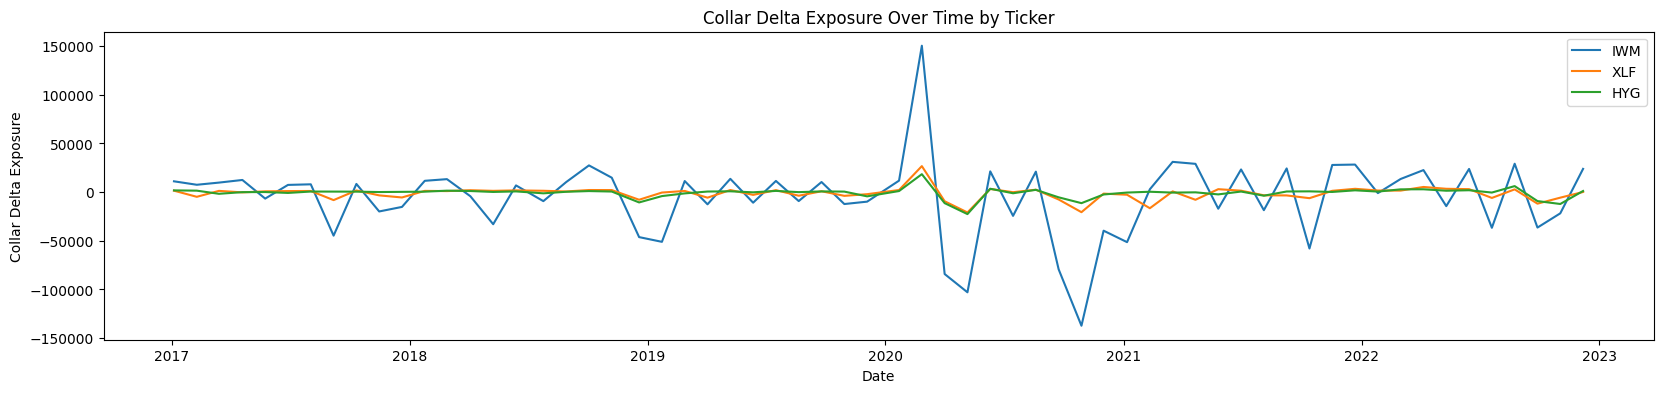

In [346]:
grapher(collar_trade_df, 'trade_PNL')

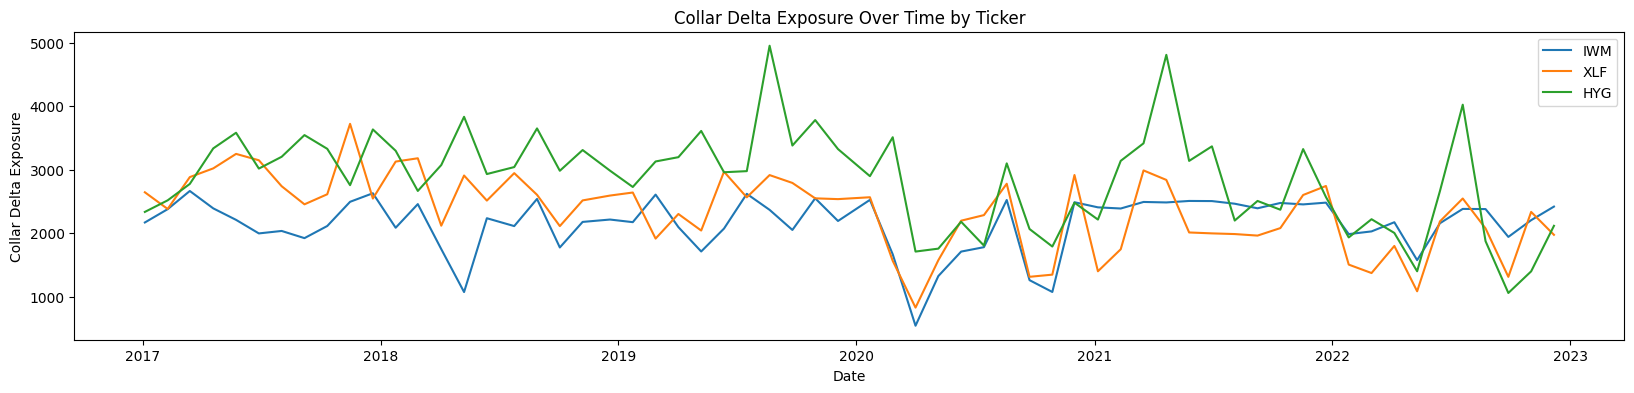

In [347]:
grapher(collar_trade_df, 'total_delta')